<a href="https://colab.research.google.com/github/ayyucedemirbas/paligemma2/blob/main/paligemma2_brain_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q roboflow supervision peft bitsandbytes transformers==4.47.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 8.8 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
from roboflow import Roboflow

rf = Roboflow(api_key="your_api_key")
project = rf.workspace("fate52-l3uqx").project("brian-tumor")
version = project.version(2)
dataset = version.download("paligemma")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to brian-tumor-2 in paligemma:: 100%|██████████| 2038/2038 [00:00<00:00, 2226.77it/s]


**NOTE:** Let's read the first few lines of the annotation file and examine the dataset format.

In [3]:
!head -n 5 {dataset.location}/dataset/_annotations.train.jsonl

{"image":"y428_jpg.rf.349d9944f2746d83268cce9abd4849be.jpg","prefix":"detect object","suffix":""}
{"image":"y435_jpg.rf.332c963a676043c27b0ebdeca05d919f.jpg","prefix":"detect object","suffix":"<loc0125><loc0203><loc0521><loc0493> object"}
{"image":"y377_jpg.rf.3381fea3a9ef0b0ea0c29c17eee2b7e9.jpg","prefix":"detect object","suffix":"<loc0121><loc0538><loc0517><loc0809> object"}
{"image":"y70_jpg.rf.36af6928e7b1bcee6087299de1258a12.jpg","prefix":"detect object","suffix":"<loc0235><loc0319><loc0361><loc0502> object"}
{"image":"y284_jpg.rf.36f551713224c791988db36d9f0f3e57.jpg","prefix":"detect object","suffix":"<loc0453><loc0174><loc0809><loc0448> object"}


In [4]:
import os
import json
import random
from PIL import Image
from torch.utils.data import Dataset


class JSONLDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self):
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx: int):
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        image = Image.open(image_path)
        return image, entry

In [5]:
train_dataset = JSONLDataset(
    jsonl_file_path=f"{dataset.location}/dataset/_annotations.train.jsonl",
    image_directory_path=f"{dataset.location}/dataset",
)
valid_dataset = JSONLDataset(
    jsonl_file_path=f"{dataset.location}/dataset/_annotations.valid.jsonl",
    image_directory_path=f"{dataset.location}/dataset",
)
test_dataset = JSONLDataset(
    jsonl_file_path=f"{dataset.location}/dataset/_annotations.test.jsonl",
    image_directory_path=f"{dataset.location}/dataset",
)

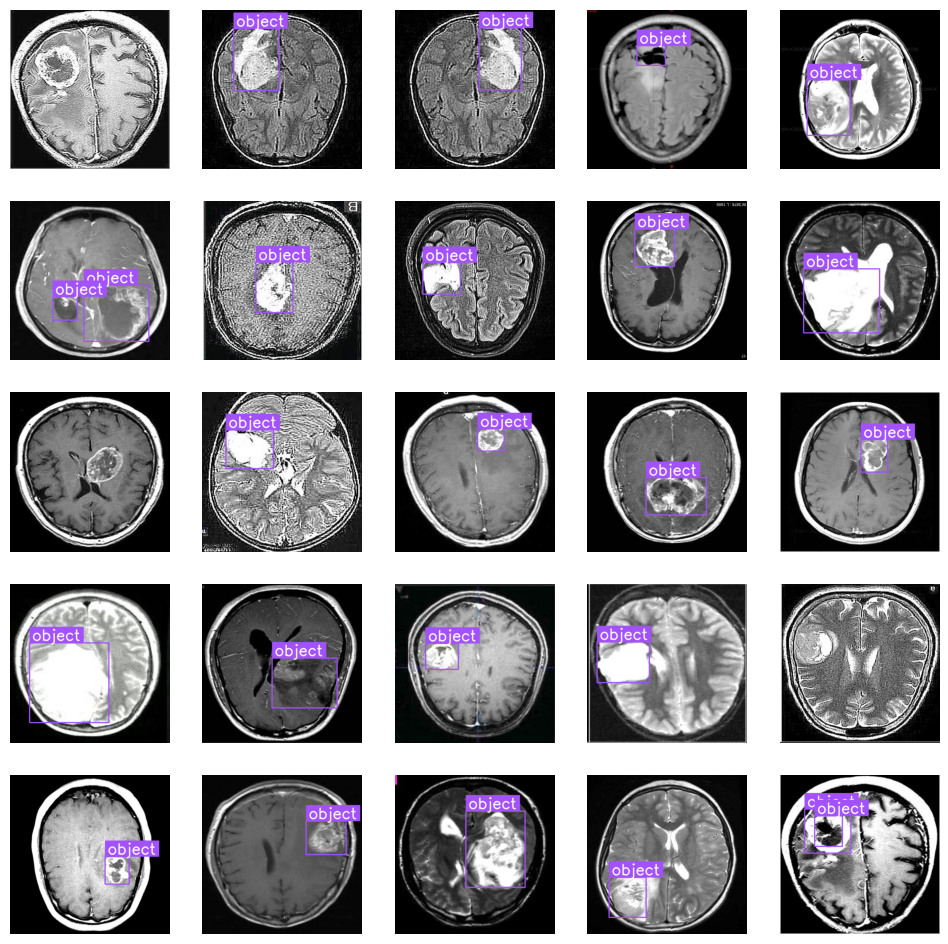

In [6]:
from tqdm import tqdm
import supervision as sv


CLASSES = train_dataset[0][1]['prefix'].replace("detect ", "").split(" ; ")

images = []
for i in range(25):
    image, label = train_dataset[i]
    detections = sv.Detections.from_lmm(
        lmm='paligemma',
        result=label["suffix"],
        resolution_wh=(image.width, image.height),
        classes=CLASSES)

    image = sv.BoxAnnotator(thickness=4).annotate(image, detections)
    image = sv.LabelAnnotator(text_scale=2, text_thickness=4).annotate(image, detections)
    images.append(image)

sv.plot_images_grid(images, (5, 5))

In [7]:
import torch
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration

MODEL_ID ="google/paligemma2-3b-pt-448"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
from huggingface_hub import notebook_login
notebook_login()

In [9]:
processor = PaliGemmaProcessor.from_pretrained(MODEL_ID)

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


preprocessor_config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

**NOTE:** Depending on the multimodal task you are trying to solve, we have prepared two training versions that optimize VRAM consumption.

- Freeze the image encoder and fine-tune only the text decoder.
- Fine-tune the entire model with LoRA and QLoRA.

In [11]:
TORCH_DTYPE = torch.bfloat16

model = PaliGemmaForConditionalGeneration.from_pretrained(MODEL_ID, torch_dtype=TORCH_DTYPE).to(DEVICE)

for param in model.vision_tower.parameters():
    param.requires_grad = False

for param in model.multi_modal_projector.parameters():
    param.requires_grad = False

config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/75.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.07G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [10]:
from transformers import BitsAndBytesConfig
from peft import get_peft_model, LoraConfig

bnb_config = BitsAndBytesConfig(
     load_in_4bit=True,
     bnb_4bit_compute_dtype=torch.bfloat16
 )
lora_config = LoraConfig(
     r=8,
     target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
     task_type="CAUSAL_LM",
 )

model = PaliGemmaForConditionalGeneration.from_pretrained(MODEL_ID, device_map="auto")
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

TORCH_DTYPE = model.dtype

config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/75.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.07G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

trainable params: 11,876,352 || all params: 3,045,003,504 || trainable%: 0.3900


In [12]:
from transformers import Trainer, TrainingArguments


def augment_suffix(suffix):
    parts = suffix.split(' ; ')
    random.shuffle(parts)
    return ' ; '.join(parts)


def collate_fn(batch):
    images, labels = zip(*batch)

    paths = [label["image"] for label in labels]
    prefixes = ["<image>" + label["prefix"] for label in labels]
    suffixes = [augment_suffix(label["suffix"]) for label in labels]

    inputs = processor(
        text=prefixes,
        images=images,
        return_tensors="pt",
        suffix=suffixes,
        padding="longest"
    ).to(TORCH_DTYPE).to(DEVICE)

    return inputs

args = TrainingArguments(
    num_train_epochs=16,
    remove_unused_columns=False,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=16,
    warmup_steps=2,
    learning_rate=2e-5,
    weight_decay=1e-6,
    adam_beta2=0.999,
    logging_steps=50,
    optim="adamw_hf",
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=1,
    output_dir="paligemma2_object_detection",
    bf16=True,
    report_to=["tensorboard"],
    dataloader_pin_memory=False
)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    args=args
)

In [13]:
trainer.train()

OutOfMemoryError: CUDA out of memory. Tried to allocate 1014.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 147.06 MiB is free. Process 2508 has 14.60 GiB memory in use. Of the allocated memory 13.74 GiB is allocated by PyTorch, and 760.18 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
image, label = test_dataset[1]
prefix = "<image>" + label["prefix"]
suffix = label["suffix"]

inputs = processor(
    text=prefix,
    images=image,
    return_tensors="pt"
).to(TORCH_DTYPE).to(DEVICE)

prefix_length = inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**inputs, max_new_tokens=256, do_sample=False)
    generation = generation[0][prefix_length:]
    decoded = processor.decode(generation, skip_special_tokens=True)
    print(decoded)

w, h = image.size
detections = sv.Detections.from_lmm(
    lmm='paligemma',
    result=decoded,
    resolution_wh=(w, h),
    classes=CLASSES)

annotated_image = image.copy()
annotated_image = sv.BoxAnnotator().annotate(annotated_image, detections)
annotated_image = sv.LabelAnnotator(smart_position=True).annotate(annotated_image, detections)
annotated_image

In [ ]:
import numpy as np
from tqdm import tqdm

images = []
targets = []
predictions = []

with torch.inference_mode():
    for i in tqdm(range(len(test_dataset))):
        image, label = test_dataset[i]
        prefix = "<image>" + label["prefix"]
        suffix = label["suffix"]

        inputs = processor(
            text=prefix,
            images=image,
            return_tensors="pt"
        ).to(TORCH_DTYPE).to(DEVICE)

        prefix_length = inputs["input_ids"].shape[-1]

        generation = model.generate(**inputs, max_new_tokens=256, do_sample=False)
        generation = generation[0][prefix_length:]
        generated_text = processor.decode(generation, skip_special_tokens=True)

        w, h = image.size
        prediction = sv.Detections.from_lmm(
            lmm='paligemma',
            result=generated_text,
            resolution_wh=(w, h),
            classes=CLASSES)

        prediction.class_id = np.array([CLASSES.index(class_name) for class_name in prediction['class_name']])
        prediction.confidence = np.ones(len(prediction))

        target = sv.Detections.from_lmm(
            lmm='paligemma',
            result=suffix,
            resolution_wh=(w, h),
            classes=CLASSES)

        target.class_id = np.array([CLASSES.index(class_name) for class_name in target['class_name']])

        images.append(image)
        targets.append(target)
        predictions.append(prediction)

In [ ]:
from supervision.metrics import MeanAveragePrecision, MetricTarget

map_metric = MeanAveragePrecision(metric_target=MetricTarget.BOXES)
map_result = map_metric.update(predictions, targets).compute()

print(map_result)

In [ ]:
map_result.plot()

In [ ]:
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

_ = confusion_matrix.plot()

In [ ]:
annotated_images = []

for i in range(25):
    image = images[i]
    detections = predictions[i]

    annotated_image = image.copy()
    annotated_image = sv.BoxAnnotator(thickness=4).annotate(annotated_image, detections)
    annotated_image = sv.LabelAnnotator(text_scale=2, text_thickness=4, smart_position=True).annotate(annotated_image, detections)
    annotated_images.append(annotated_image)

sv.plot_images_grid(annotated_images, (5, 5))